In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.core.pylabtools as pylabtools # for figsize
import seaborn as sns



def mask_data(data,*args):
    mask_and=np.array(args).all(0)
    return data[mask_and]

## Start running from here

In [4]:
nd=pd.read_csv("classification_by_hour_data_priority_3.csv")
nd.head()

,delta_time,date,month,day,time_bin,delta_date,total,number_ambulances_engaged,total_calls
0,0,2004-01-01,1,3,0,0,6,6,6
1,1,2004-01-01,1,3,1,0,6,9,6
2,2,2004-01-01,1,3,2,0,2,3,2
3,3,2004-01-01,1,3,3,0,3,3,3
4,4,2004-01-01,1,3,4,0,2,2,2


In [5]:
# these two lines do nothign but since the variables beneath use these names and I didnt want to go back and change
# stuff I keep them

nd['total']=nd.number_ambulances_engaged # if we want total_calls change this to total calls
nd.drop(['delta_date','number_ambulances_engaged','total_calls'],axis=1,inplace=True)

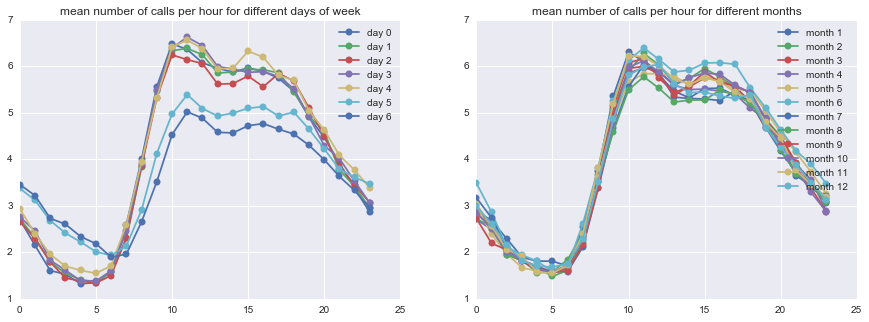

In [6]:
# we plot the behavior of mean number of calls by the hour for weekdays and months

pylabtools.figsize(15,5)
plt.subplot(121)
nd_mean=nd.groupby(['day','time_bin']).mean().reset_index().drop('month',axis=1)
for i in range(7):
    data_masked=mask_data(nd_mean,nd_mean.day==i)
    plt.plot(data_masked.time_bin,data_masked.total,"-o",label="day "+str(i))
plt.title("mean number of calls per hour for different days of week")
plt.legend()

plt.subplot(122)
nd_mean=nd.groupby(['month','time_bin']).mean().reset_index().drop('day',axis=1)
for i in range(1,13):
    data_masked=mask_data(nd_mean,nd_mean.month==i)
    plt.plot(data_masked.time_bin,data_masked.total,"-o",label="month "+str(i))
plt.title("mean number of calls per hour for different months")
plt.legend()

In [7]:
special_days_data=pd.read_csv('special_days_by_hour.csv')

In [8]:
special_days_data['delta_time']=special_days_data.index

In [9]:
special_days_data.drop('date',axis=1,inplace=True)
special_days_data.head()


,special_day,delta_time
0,True,0
1,True,1
2,True,2
3,True,3
4,True,4


In [10]:
special_days_data.special_day=pd.factorize(special_days_data.special_day)[0]

In [11]:
nd_merged=nd.merge(special_days_data,left_on='delta_time',right_on='delta_time')

In [12]:
nd_merged.head()

,delta_time,date,month,day,time_bin,total,special_day
0,0,2004-01-01,1,3,0,6,0
1,1,2004-01-01,1,3,1,9,0
2,2,2004-01-01,1,3,2,3,0
3,3,2004-01-01,1,3,3,3,0
4,4,2004-01-01,1,3,4,2,0


In [13]:
weather_data=pd.read_csv('all_weather_temp.csv')

m=weather_data[weather_data.temperature != "--"].temperature.astype(float).mean()
weather_data.loc[weather_data.temperature == "--",'temperature']=m
weather_data.temperature=weather_data.temperature.astype(float)

In [14]:
weather_data=pd.read_csv('all_weather_vars_clean.csv')

In [15]:
nd_merged=nd_merged.merge(weather_data,left_on='delta_time',right_on='hour')

In [16]:
cond1=np.array([nd_merged.total.values>13,nd_merged.time_bin.values>=7,nd_merged.time_bin.values<19]).all(0)
cond2=np.array([nd_merged.total.values>9,nd_merged.time_bin.values<7]).all(0)
cond3=np.array([nd_merged.total.values>9,nd_merged.time_bin.values>=19]).all(0)
combined_condition=np.array([cond1,cond2,cond3]).any(0)

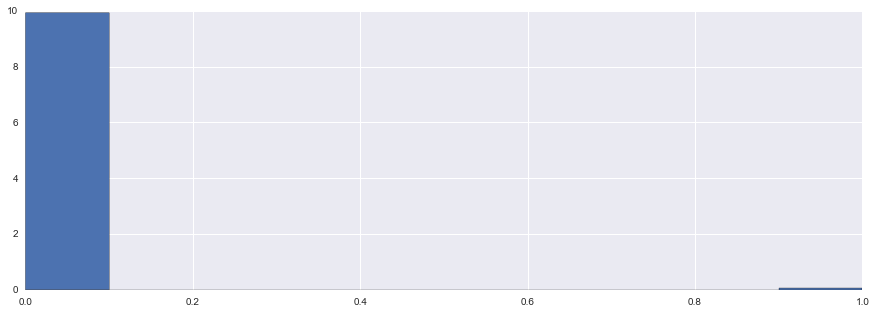

In [17]:

# another approach would be to ask if there is some persistance in the hours that see above average and those that see belo
# this would be some ising model like clumpign of spins
# we will try this


nd_merged['busy']=(combined_condition).astype(int)

# this gives about 15% of the days busy. if this doesn't 'feel' right we can reduce the threshold to increase
# the number of days classified as busy
nd_merged['busy'].hist(normed='True')

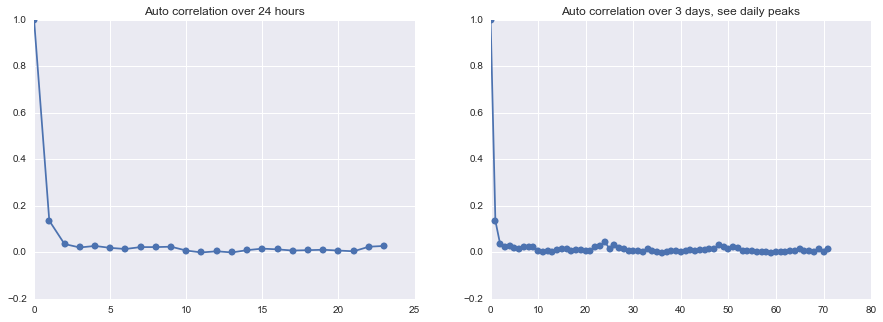

In [18]:
# Now we can test Niquille's intuition. He seems to claim busy hours come in chunks. That should mean that there
# should be correlations over the first few hours. However we fail to see this.


pylabtools.figsize(15,5)
plt.subplot(121)
autocorrelations=pd.Series([nd_merged.busy.autocorr(lag=l) for l in range(24)])
plt.plot(pd.rolling_mean(autocorrelations,1),"-o")
plt.title("Auto correlation over 24 hours")

plt.subplot(122)
autocorrelations=pd.Series([nd_merged.busy.autocorr(lag=l) for l in range(3*24)])
plt.plot(pd.rolling_mean(autocorrelations,1),"-o")

plt.title("Auto correlation over 3 days, see daily peaks")

In [19]:
nd_final=nd_merged
a=nd_final.busy[1:]
b=nd_final.busy[:-1]

from scipy.stats import spearmanr

spearmanr(a,b)

SpearmanrResult(correlation=0.1357738476900634, pvalue=0.0)

In [20]:
nd_merged[['special_day','busy']].corr()

,special_day,busy
special_day,1.000000,0.006574
busy,0.006574,1.000000


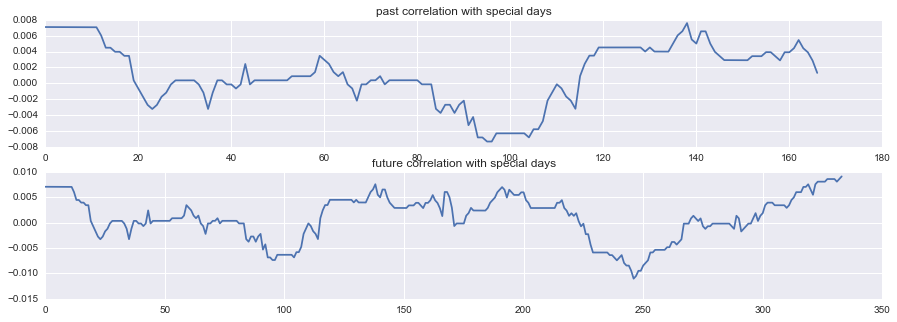

In [21]:
nd_final=nd_merged

cor=[]

plt.subplot(211)
from scipy.stats import spearmanr
for k in range(1,24*7):
    a=nd_final.busy[k:]
    b=nd_final.special_day[:-k]
    cor.append(spearmanr(a,b)[0])
    
plt.plot(cor)
plt.title("past correlation with special days")

plt.subplot(212)
from scipy.stats import spearmanr
for k in range(1,24*7):
    a=nd_final.busy[:-k]
    b=nd_final.special_day[k:]
    cor.append(spearmanr(a,b)[0])
    
plt.plot(cor)
plt.title("future correlation with special days")

In [22]:
nd_merged.drop('hour',axis=1,inplace=True)
nd_merged.head()

,delta_time,date,month,day,time_bin,total,special_day,temperature,temperature_wind,temperature_dew_point,wind_speed,humidity,pressure,busy
0,0,2004-01-01,1,3,0,6,0,2.2,-1.3,-2.0,13.0,74,1020.4,0
1,1,2004-01-01,1,3,1,9,0,1.9,-1.3,-2.1,11.1,75,1020.6,0
2,2,2004-01-01,1,3,2,3,0,2.2,-0.9,-1.8,11.1,75,1020.9,0
3,3,2004-01-01,1,3,3,3,0,2.2,-0.5,-1.7,9.3,75,1020.1,0
4,4,2004-01-01,1,3,4,2,0,1.7,-1.1,-2.1,9.3,76,1019.5,0


In [23]:
nd_merged.columns

Index([u'delta_time', u'date', u'month', u'day', u'time_bin', u'total',
       u'special_day', u'temperature', u'temperature_wind',
       u'temperature_dew_point', u'wind_speed', u'humidity', u'pressure',
       u'busy'],
      dtype='object')

In [24]:
total_lag_hours=24
for i in range(1,total_lag_hours+1):
    nd_merged['lag_busy'+str(i)]=nd_merged.busy.shift(i)
    nd_merged['lag_temperature'+str(i)]=nd_merged.temperature.shift(i)
    nd_merged['lag_temperature_wind'+str(i)]=nd_merged.temperature.shift(i)
    nd_merged['lag_temperature_dew_point'+str(i)]=nd_merged.temperature.shift(i)
    nd_merged['lag_wind_speed'+str(i)]=nd_merged.temperature.shift(i)
    nd_merged['lag_wind_humidity'+str(i)]=nd_merged.temperature.shift(i)
    nd_merged['lag_wind_pressure'+str(i)]=nd_merged.temperature.shift(i)



cols_busy=['lag_busy'+str(i) for i in range(1,total_lag_hours+1) ]
cols_temperature=['lag_temperature'+str(i) for i in range(1,total_lag_hours+1) ]
cols_temperature_wind=['lag_temperature_wind'+str(i) for i in range(1,total_lag_hours+1) ]
cols_temperature_dew_point=['lag_temperature_dew_point'+str(i) for i in range(1,total_lag_hours+1) ]
cols_wind_speed=['lag_wind_speed'+str(i) for i in range(1,total_lag_hours+1) ]
cols_wind_humidity=['lag_wind_humidity'+str(i) for i in range(1,total_lag_hours+1) ]
cols_wind_pressure=['lag_wind_pressure'+str(i) for i in range(1,total_lag_hours+1) ]

In [25]:
# We cant use the first 'total_lag_days' as they do not have complete information accroding to the above model
nd_final=nd_merged[total_lag_hours:]

In [26]:
nd_final.drop(['delta_time'],axis=1,inplace=True)

/Users/bchowdhu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [27]:
nd_final.head()

,date,month,day,time_bin,total,special_day,temperature,temperature_wind,temperature_dew_point,wind_speed,...,lag_wind_speed23,lag_wind_humidity23,lag_wind_pressure23,lag_busy24,lag_temperature24,lag_temperature_wind24,lag_temperature_dew_point24,lag_wind_speed24,lag_wind_humidity24,lag_wind_pressure24
24,2004-01-02,1,4,0,2,1,0.5,0.5,-0.2,0.0,...,1.9,1.9,1.9,0,2.2,2.2,2.2,2.2,2.2,2.2
25,2004-01-02,1,4,1,1,1,0.4,0.4,-0.4,0.0,...,2.2,2.2,2.2,0,1.9,1.9,1.9,1.9,1.9,1.9
26,2004-01-02,1,4,2,0,1,0.7,0.7,-0.4,1.9,...,2.2,2.2,2.2,0,2.2,2.2,2.2,2.2,2.2,2.2
27,2004-01-02,1,4,3,0,1,0.7,0.7,-0.4,3.7,...,1.7,1.7,1.7,0,2.2,2.2,2.2,2.2,2.2,2.2
28,2004-01-02,1,4,4,0,1,0.5,0.5,-0.4,0.0,...,1.5,1.5,1.5,0,1.7,1.7,1.7,1.7,1.7,1.7


In [28]:
nd_final.drop('date',axis=1,inplace=True)
from sklearn.preprocessing import Imputer
imp=Imputer()
cols_nd_final=nd_final.columns
nd_final=pd.DataFrame(imp.fit_transform(nd_final),columns=cols_nd_final)

/Users/bchowdhu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [29]:
nd_final.head()

,month,day,time_bin,total,special_day,temperature,temperature_wind,temperature_dew_point,wind_speed,humidity,...,lag_wind_speed23,lag_wind_humidity23,lag_wind_pressure23,lag_busy24,lag_temperature24,lag_temperature_wind24,lag_temperature_dew_point24,lag_wind_speed24,lag_wind_humidity24,lag_wind_pressure24
0,1,4,0,2,1,0.5,0.5,-0.2,0.0,95,...,1.9,1.9,1.9,0,2.2,2.2,2.2,2.2,2.2,2.2
1,1,4,1,1,1,0.4,0.4,-0.4,0.0,94,...,2.2,2.2,2.2,0,1.9,1.9,1.9,1.9,1.9,1.9
2,1,4,2,0,1,0.7,0.7,-0.4,1.9,92,...,2.2,2.2,2.2,0,2.2,2.2,2.2,2.2,2.2,2.2
3,1,4,3,0,1,0.7,0.7,-0.4,3.7,92,...,1.7,1.7,1.7,0,2.2,2.2,2.2,2.2,2.2,2.2
4,1,4,4,0,1,0.5,0.5,-0.4,0.0,94,...,1.5,1.5,1.5,0,1.7,1.7,1.7,1.7,1.7,1.7


In [30]:
from sklearn.cross_validation import train_test_split
train,test=train_test_split(nd_final)
models={}

In [73]:
cols_busy=['lag_busy'+str(i) for i in range(1,total_lag_hours+1) ]
cols_temperature=['lag_temperature'+str(i) for i in range(1,total_lag_hours+1) ]
cols_temperature_wind=['lag_temperature_wind'+str(i) for i in range(1,total_lag_hours+1) ]
cols_temperature_dew_point=['lag_temperature_dew_point'+str(i) for i in range(1,total_lag_hours+1) ]
cols_wind_speed=['lag_wind_speed'+str(i) for i in range(1,total_lag_hours+1) ]
cols_wind_humidity=['lag_wind_humidity'+str(i) for i in range(1,total_lag_hours+1) ]
cols_wind_pressure=['lag_wind_pressure'+str(i) for i in range(1,total_lag_hours+1) ]


numerical_cols=cols_temperature+cols_temperature_wind+cols_temperature_dew_point+cols_wind_speed+cols_wind_humidity+cols_wind_pressure
catecorical_cols=cols_busy+['day','month','time_bin','special_day']


In [463]:
X_train_numerical=train[numerical_cols]
X_train_categorical=train[catecorical_cols]
y_train=train.busy


X_test_numerical=test[numerical_cols]
X_test_categorical=test[catecorical_cols]
y_test=test.busy



In [464]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
enc.fit(X_train_categorical)
X_train_categorical=enc.transform(X_train_categorical).toarray()
X_test_categorical=enc.transform(X_test_categorical).toarray()

In [465]:
X_train=np.hstack((X_train_numerical,X_train_categorical))
X_test=np.hstack((X_test_numerical,X_test_categorical))

In [466]:
from sklearn.ensemble import ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [468]:
#clf=ExtraTreesClassifier(n_estimators=1000,n_jobs=-1)
clf=LogisticRegression()
#clf=SVC()
#clf=GradientBoostingClassifier()
clf.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [469]:
#models['two']=[enc,clf]

In [470]:
y_pred_rt = clf.predict_proba(X_test)[:, 1]

In [471]:
from sklearn.metrics import roc_curve, roc_auc_score,confusion_matrix
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

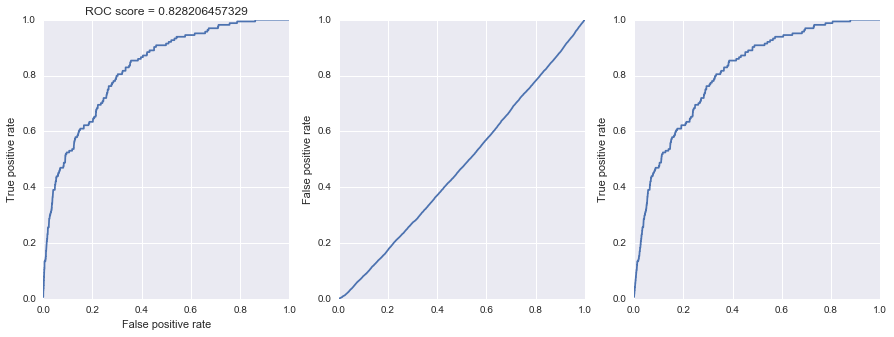

In [472]:
pylabtools.figsize(15,5)

plt.subplot(131)
plt.plot(fpr_rt_lm, tpr_rt_lm)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC score = "+str(roc_auc_score(y_test, y_pred_rt)))
plt.subplot(132)
plt.plot(np.linspace(0,1,fpr_rt_lm.shape[0]),fpr_rt_lm)
plt.ylabel('False positive rate')
plt.subplot(133)
plt.plot(np.linspace(0,1,fpr_rt_lm.shape[0]),tpr_rt_lm)
plt.ylabel('True positive rate')

In [36]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train = nd_final
target = 'busy'


In [37]:
X_numerical=nd_final[numerical_cols]
X_categorical=nd_final[catecorical_cols]
y_train=nd_final.busy
X=np.hstack((X_numerical,X_categorical))


nd_final['target']=nd_final.busy

In [69]:
import xgboost as xgb

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics={'auc'}, show_progress=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['target'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['target'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['target'], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [75]:
from xgboost.sklearn import XGBClassifier

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
predictors=catecorical_cols +numerical_cols

In [76]:
modelfit(xgb1, train, predictors)

[0]	cv-test-auc:0.6804184+0.0604496903502	cv-train-auc:0.6906024+0.0604511102515
[1]	cv-test-auc:0.747823+0.0279360402133	cv-train-auc:0.7505942+0.0330226294374
[2]	cv-test-auc:0.7630272+0.0223161331095	cv-train-auc:0.7675012+0.0226465229949
[3]	cv-test-auc:0.764919+0.0191148569966	cv-train-auc:0.7709898+0.01895461674
[4]	cv-test-auc:0.764264+0.0188010235041	cv-train-auc:0.773409+0.0199310372535
[5]	cv-test-auc:0.7748598+0.00956933636988	cv-train-auc:0.7860656+0.00473679885999
[6]	cv-test-auc:0.775613+0.00997258999458	cv-train-auc:0.7895078+0.00504512835912
[7]	cv-test-auc:0.775897+0.0104308453924	cv-train-auc:0.7903766+0.00444688585867
[8]	cv-test-auc:0.7779944+0.0113961480264	cv-train-auc:0.7940642+0.00741624064874
[9]	cv-test-auc:0.780009+0.0115081540309	cv-train-auc:0.7972196+0.00705322761862
[10]	cv-test-auc:0.7816498+0.0102825182791	cv-train-auc:0.7979852+0.00653000047167
[11]	cv-test-auc:0.7848838+0.0142978563204	cv-train-auc:0.802185+0.00305032306486
[12]	cv-test-auc:0.78472+0.

KeyboardInterrupt: 

In [77]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[catecorical_cols],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.82258, std: 0.02175, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.82376, std: 0.02166, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.82295, std: 0.01951, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.81845, std: 0.02008, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.81806, std: 0.02289, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.81824, std: 0.02185, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.81210, std: 0.01975, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.81173, std: 0.02396, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.81173, std: 0.01931, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.80455, std: 0.02069, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.80872, std: 0.02227, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.80949, std: 0.02194, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 3

In [78]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[2,3,4]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.80700, std: 0.02283, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: 0.80726, std: 0.02270, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.80555, std: 0.02323, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: 0.80049, std: 0.01874, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.80522, std: 0.01901, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.80277, std: 0.02012, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.79305, std: 0.01904, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.79767, std: 0.01851, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.79762, std: 0.01933, params: {'max_depth': 4, 'min_child_weight': 4}],
 {'max_depth': 2, 'min_child_weight': 3},
 0.80726445765125932)

In [425]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.83195, std: 0.01756, params: {'gamma': 0.0},
  mean: 0.83195, std: 0.01766, params: {'gamma': 0.1},
  mean: 0.83195, std: 0.01767, params: {'gamma': 0.2},
  mean: 0.83199, std: 0.01765, params: {'gamma': 0.3},
  mean: 0.83186, std: 0.01789, params: {'gamma': 0.4}],
 {'gamma': 0.3},
 0.83198670159251376)

In [427]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=3, gamma=.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.82945, std: 0.01836, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.83168, std: 0.01939, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.83344, std: 0.01834, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.83171, std: 0.01749, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.82796, std: 0.01754, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.83196, std: 0.01768, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.83286, std: 0.01713, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.83097, std: 0.01696, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.82830, std: 0.01722, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.83168, std: 0.01703, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.83199, std: 0.01765, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.83158, std: 0.01752, params: {'subsample': 0.9, 'colsample_bytree'

In [428]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=3, gamma=.3, subsample=0.8, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.83344, std: 0.01834, params: {'reg_alpha': 1e-05},
  mean: 0.83361, std: 0.01821, params: {'reg_alpha': 0.01},
  mean: 0.83325, std: 0.01857, params: {'reg_alpha': 0.1},
  mean: 0.83243, std: 0.01826, params: {'reg_alpha': 1},
  mean: 0.75911, std: 0.02366, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.01},
 0.83361218484623811)

In [429]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=3, gamma=.3, subsample=0.8, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[predictors])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.83344, std: 0.01834, params: {'reg_alpha': 0},
  mean: 0.83358, std: 0.01824, params: {'reg_alpha': 0.001},
  mean: 0.83355, std: 0.01832, params: {'reg_alpha': 0.005},
  mean: 0.83361, std: 0.01821, params: {'reg_alpha': 0.01},
  mean: 0.83374, std: 0.01826, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0.05},
 0.83373754033092062)

In [430]:
estimator = XGBClassifier( learning_rate =0.01, n_estimators=5000, max_depth=2,
 min_child_weight=3, gamma=.3, subsample=0.8, colsample_bytree=0.6, reg_alpha=0.05,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)

In [432]:
from sklearn import cross_validation

In [434]:
scores = cross_validation.cross_val_score(estimator, train[predictors], train[target], cv=5, scoring='roc_auc')
print "mean: %f, std: %f" %(np.mean(scores),np.std(scores))

mean: 0.826408, std: 0.016814


In [ ]:









GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=3, gamma=.3, subsample=0.8, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)